In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
import os
import SimpleITK as sitk
from radiomics import featureextractor, shape, shape2D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict
import datetime
import glob


In [184]:

marksheet_path = r'Data\marksheet.csv'
source_PI_CAI = r'Data/picai_public_images'
source_PI_CAI_whole_gland_Guerbet23 = r'Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23'
source_PI_CAI_Human = r'Data/picai_public_images/csPCa_lesion_delineations/human_expert/original'
source_PI_CAI_resampled = r'Data/t2w_spacing_resampled'
source_PI_CAI_resampled_whole_gland_Guerbet23 = r'Data/Guerbet23_resampled'
source_PI_CAI_resampled_Human = r'Data/Human_resampled'
def find_t2W_files(dir, combined_ids, fileinfo):
    dir = os.path.normpath(dir)
    t2w_file_paths = []

    for subdir, dirs, files in os.walk(dir):
        subdir = os.path.normpath(subdir)
        for file in files:
            if any(file.endswith(combined_id + fileinfo) for combined_id in combined_ids):
                t2w_file_paths.append(os.path.join(subdir, file))

    return t2w_file_paths

def preprocess_data(marksheet_df):
    print(f"Initial dataset length: {len(marksheet_df)}")

    # 1. Drop data with missing values in the column "PSA" or "Volume"
    marksheet_df = marksheet_df.dropna(subset=['psa'])
    print(f"Dataset length after dropping rows with missing psa: {len(marksheet_df)}")
     
    marksheet_df = marksheet_df.dropna(subset=['prostate_volume'])
    print(f"Dataset length after dropping rows with missing prostate volume: {len(marksheet_df)}")
    # 2. Filter out patients with no biopsy
    biopsy_filter = marksheet_df['histopath_type'].isin(['MRBx', 'SysBx', 'SysBx+MRBx'])
    marksheet_df = marksheet_df[biopsy_filter]
    print(f"Dataset length after filtering biopsies: {len(marksheet_df)}")

    # 3. Convert case_csPCa to binary (1: True, 0: False)
    marksheet_df['case_csPCa'] = marksheet_df['case_csPCa'].apply(lambda x: 1 if x.upper() == 'YES' else 0)
    
    # Combined ids for use as a unique identifier
    sorted_patient_id = marksheet_df['patient_id']
    sorted_study_id = marksheet_df['study_id']
    combined_ids = sorted_patient_id.astype(str) + '_' + sorted_study_id.astype(str)

    return marksheet_df, combined_ids

def save_df(df, dir, filename, gland_type):
    path = os.path.join(dir, f"{filename}_{gland_type}.csv")
    df.to_csv(path, index=False)
    print(f"File saved as {path}")

def calculate_psad(df):
    mask = df['psad'].isna() & df['psa'].notna() & df['prostate_volume'].notna()
    df.loc[mask, 'psad'] = (df.loc[mask, 'psa'] / df.loc[mask, 'prostate_volume']).round(2)
    
    return df


In [96]:
marksheet_df = pd.read_csv(marksheet_path)
Preprocessed_marksheet_df, combined_ids = preprocess_data(marksheet_df)
Preprocessed_marksheet_df = calculate_psad(Preprocessed_marksheet_df)
save_df(Preprocessed_marksheet_df, 'Data', 'Preprocessed_marksheet', 'all')
Preprocessed_marksheet_df


Initial dataset length: 1500
Dataset length after dropping rows with missing psa: 1460
Dataset length after dropping rows with missing prostate volume: 1439
Dataset length after filtering biopsies: 945
File saved as Data\Preprocessed_marksheet_all.csv


,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,center
0,10000,1000000,2019-07-02,73,7.70,0.14,55.0,MRBx,0+0,0,0,0,PCNN
3,10003,1000003,2019-04-05,72,13.00,0.18,71.5,SysBx,0+0,0,0,0,ZGT
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,0,RUMC
5,10005,1000005,2012-07-18,64,12.10,0.24,51.0,MRBx,"4+3,0+0","3,0",3,1,RUMC
6,10006,1000006,2020-10-23,73,6.20,0.23,27.0,SysBx+MRBx,"0+0,3+3","0,1",1,0,ZGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,1,RUMC
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,1,RUMC
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,0,RUMC
1498,11474,1001498,2016-05-03,71,12.00,0.14,83.0,MRBx,3+3,1,1,0,PCNN


203 388 340


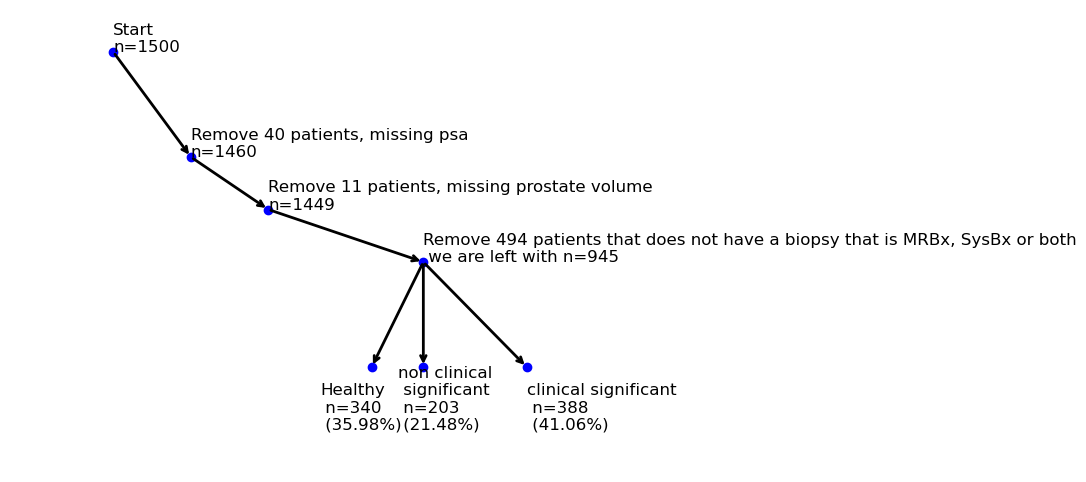

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_ISUP,case_ISUP,case_csPCa,center,lesion_GS
0,10000,1000000,2019-07-02,73,7.70,0.14,55.0,MRBx,0,0,0,PCNN,0+0
1,10003,1000003,2019-04-05,72,13.00,0.18,71.5,SysBx,0,0,0,ZGT,0+0
2,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0,0",0,0,RUMC,0+0
3,10005,1000005,2012-07-18,64,12.10,0.24,51.0,MRBx,"3,0",3,1,RUMC,4+3
4,10006,1000006,2020-10-23,73,6.20,0.23,27.0,SysBx+MRBx,"0,1",1,0,ZGT,3+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"2,1",2,1,RUMC,3+4
941,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,2,2,1,RUMC,3+4
942,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0,0,0,RUMC,0+0
943,11474,1001498,2016-05-03,71,12.00,0.14,83.0,MRBx,1,1,0,PCNN,3+3


In [ ]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
df_exploded = df

def get_highest_gleason_score(gleason_scores):
    """
    Function to get the highest Gleason score from a list of scores.
    """
    score_mapping = {
        "0+0": 0,
        "3+3": 1,
        "3+4": 2,
        "4+3": 3,
        "4+4": 4,
        "5+4": 5,
        "4+5": 6,
        "5+5": 7
    }
    highest_score = max(gleason_scores, key=lambda x: score_mapping.get(x, -1))
    return highest_score

# Split the lesion_GS column by comma and explode the DataFrame to handle multiple scores
df['lesion_GS'] = df['lesion_GS'].str.split(',')
df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

# Calculate the counts for each category
gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

# Print the counts
print(gleason_7_low, gleason_7_high, negative_biopsy)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0.2, 0.35, 0.5, 0.8, 0.7, 0.8, 1], [2, 1.5, 1.25, 1, 0.5, 0.5, 0.5], 'o', color='blue')
ax.annotate("", xy=(0.35, 1.5), xytext=(0.2, 2), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.5, 1.25), xytext=(0.35, 1.5), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 1), xytext=(0.5, 1.25), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.7, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(1, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))

ax.text(0.2, 2, "Start\nn=1500", fontsize=12)
ax.text(0.35, 1.5, "Remove 40 patients, missing psa \nn=1460", fontsize=12)
ax.text(0.5, 1.25, "Remove 11 patients, missing prostate volume \nn=1449", fontsize=12)
ax.text(0.8, 1, "Remove 494 patients that does not have a biopsy that is MRBx, SysBx or both\n we are left with n=945", fontsize=12)
ax.text(0.6, 0.2, f"Healthy\n n={negative_biopsy} \n ({(negative_biopsy / 945) * 100:.2f}%)", fontsize=12)
ax.text(0.75, 0.2, f"non clinical \n significant \n n={gleason_7_low} \n ({(gleason_7_low / 945) * 100:.2f}%) " , fontsize=12)
ax.text(1, 0.2, f"clinical significant\n n={gleason_7_high} \n ({(gleason_7_high / 945) * 100:.2f}%)", fontsize=12)

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 2.2)
ax.axis("off")

plt.show()

In [ ]:
# df = Preprocessed_marksheet_df
# def count_case_csPCa(df):
#     """
#     Function to count the number of positive (1) and negative (0) cases in the case_csPCa column.
#     """
#     positive_cases = df[df['case_csPCa'] == 1].shape[0]
#     negative_cases = df[df['case_csPCa'] == 0].shape[0]
    
#     return positive_cases, negative_cases

# # Count the positive and negative cases
# positive_cases, negative_cases = count_case_csPCa(df)

# # Print the results
# print(f"Number of positive cases (1): {positive_cases}")
# print(f"Number of negative cases (0): {negative_cases}")

Number of positive cases (1): 393
Number of negative cases (0): 552


In [104]:
def median_iqr(series):
    return f"{series.median():.2f} ({series.quantile(0.25):.2f}-{series.quantile(0.75):.2f})"



def generate_summary_table(df):
    N = len(df)
    age = df['patient_age']
    psa = df['psa']
    prostate_volume = df['prostate_volume']
    psad = df['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    psa_median_iqr = median_iqr(psa)
    psad_median_iqr = median_iqr(psad)
    prostate_volume_median_std = f"{prostate_volume.median():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"


    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': age_mean_std,
        'PSA(ng/ml)': psa_median_iqr,
        'PSAD(ng/ml^2)': psad_median_iqr,
        'Prostate Volume(ml)': prostate_volume_median_std,
        "< 35 mL": f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)",
        "35 - 50 mL": f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)",
        "> 50 mL": f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)",
        "Biopsy type": "".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]),
        "Biopsy results:": "",
        "Negative:": f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)",
        "Gleason score ≤7:": f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)",
        "Gleason score >7:": f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)",
    }
    table_df = pd.DataFrame.from_dict(table_data, orient='index', columns=[f'Patients ({N})'])
    return table_df
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table(df)
print(summary_table)


                                                        Patients (945)
Age(Years)                                             66.47, +-  7.05
PSA(ng/ml)                                           9.00 (6.10-14.00)
PSAD(ng/ml^2)                                         0.18 (0.11-0.28)
Prostate Volume(ml)                                   51.00, +-  31.49
< 35 mL                                                   197 (20.85%)
35 - 50 mL                                                245 (25.93%)
> 50 mL                                                   503 (53.23%)
Biopsy type          MRBx: 529 (55.98%)SysBx: 211 (22.33%)SysBx+MRB...
Biopsy results:                                                       
Negative:                                                 340 (35.98%)
Gleason score ≤7:                                         203 (21.48%)
Gleason score >7:                                         388 (41.06%)


In [22]:
fileInfoT2w = '_t2w.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_whole_gland_Guerbet23, combined_ids, fileInfo)
Human_nii_gz_paths = find_t2W_files(source_PI_CAI_Human, combined_ids, fileInfo)

In [23]:
t2w_patient_ids = [path.split('\\')[-2] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
Human_nii_gz_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Human_nii_gz_paths]

t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Nii_gz_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
Human_df = pd.DataFrame({'Nii_gz_path': Human_nii_gz_paths, 'patient_id': Human_nii_gz_patient_ids})

df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')


Image shape: (31, 640, 640)


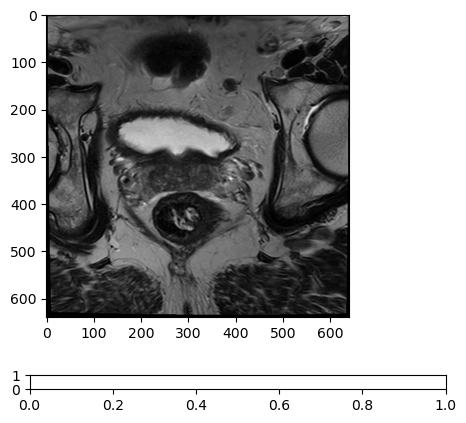

In [24]:
file_path = r"Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha"
image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

print(f"Image shape: {image_data.shape}")

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

axlayer = plt.axes([0.25, 0.1, 0.65, 0.03])

ax.imshow(image_data[18, :, :], cmap='gray')

plt.show()

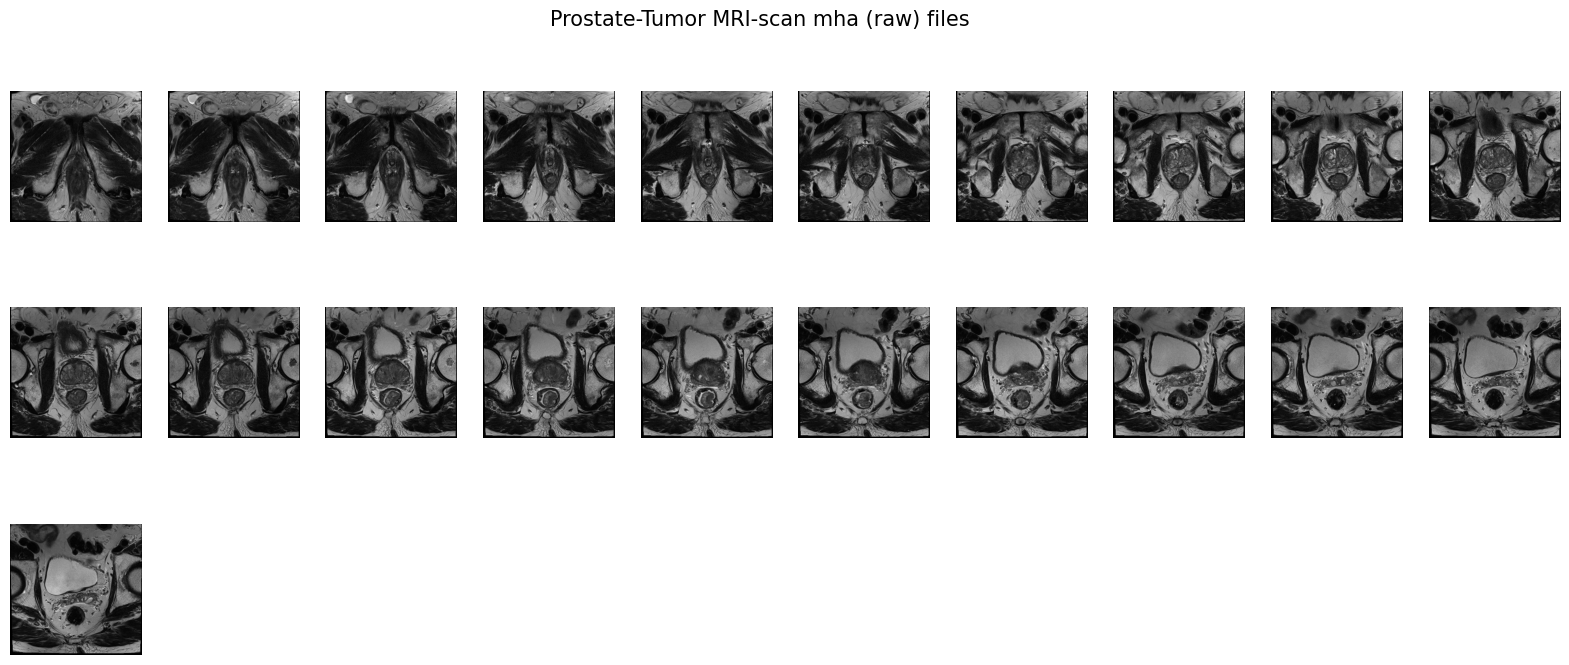

In [25]:
file_path = r"Data\picai_public_images\picai_public_images_fold1\10008\10008_1000008_t2w.mha"
image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

if image_data.max() > 0:
    image_data = image_data / image_data.max()

num_slices = image_data.shape[0]

cols = 10
rows = int(np.ceil(num_slices / cols))

plt.figure(figsize=(20, rows * 2.5))
plt.gray()
plt.subplots_adjust(hspace=0.5)

for i in range(num_slices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')

plt.suptitle('Prostate-Tumor MRI-scan mha (raw) files', size=15)
plt.show()

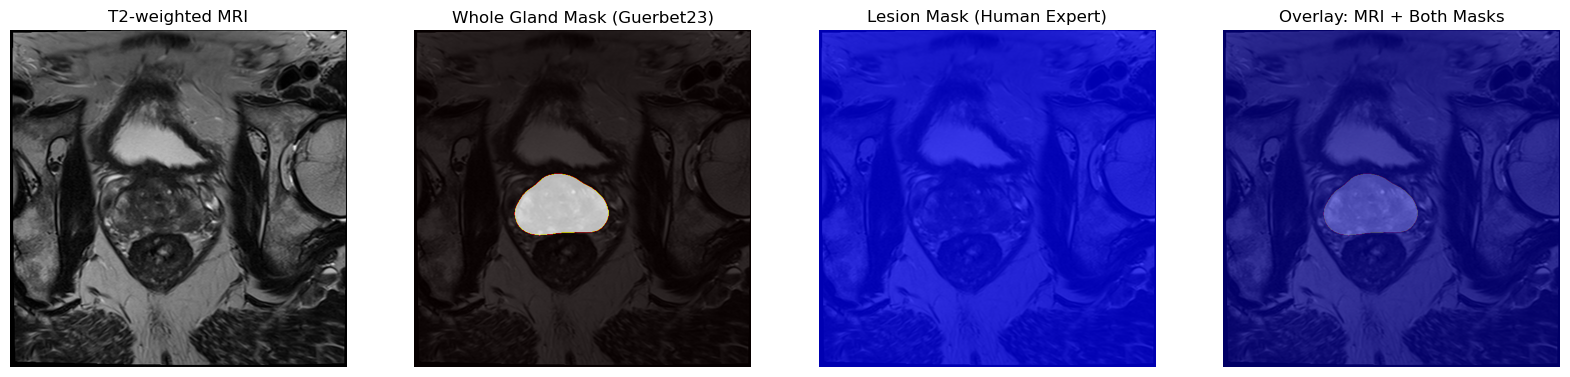

In [26]:
def load_nifti_image(file_path):
    img = sitk.ReadImage(file_path)
    return sitk.GetArrayFromImage(img) 

patient_id = df_path_merged_Guerbet23.iloc[0]['patient_id']  

t2w_path = df_path_merged_Guerbet23.iloc[0]['T2w_path']
guerbet23_mask_path = df_path_merged_Guerbet23.iloc[0]['Nii_gz_path']
human_mask_path = df_path_merged_Human.iloc[0]['Nii_gz_path']

t2w_image = load_nifti_image(t2w_path)
guerbet23_mask = load_nifti_image(guerbet23_mask_path)
human_mask = load_nifti_image(human_mask_path) 

t2w_image = t2w_image / np.max(t2w_image)

mid_slice = t2w_image.shape[0] // 2

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(t2w_image[mid_slice], cmap='gray')
ax[0].set_title("T2-weighted MRI")

ax[1].imshow(t2w_image[mid_slice], cmap='gray')
ax[1].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.7)
ax[1].set_title("Whole Gland Mask (Guerbet23)")

ax[2].imshow(t2w_image[mid_slice], cmap='gray')
ax[2].imshow(human_mask[mid_slice], cmap='winter', alpha=0.7)
ax[2].set_title("Lesion Mask (Human Expert)")

ax[3].imshow(t2w_image[mid_slice], cmap='gray')
ax[3].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
ax[3].imshow(human_mask[mid_slice], cmap='winter', alpha=0.4)
ax[3].set_title("Overlay: MRI + Both Masks")

for a in ax:
    a.axis("off")

plt.show()

In [112]:
def find_significant_correlations(df, processed_subset, target_variable='case_csPCa', threshold=0.0):
    df['patient_id'] = df['patient_id'].astype(int)

    merge_df = pd.merge(processed_subset, df, left_on='patient_id', right_on='patient_id', how='left')
    merge_df.drop('patient_id', axis=1, inplace=True)
    correlation_matrix = merge_df.corr()
    absolute_correlation = correlation_matrix[target_variable].abs()
    significant_correlations = absolute_correlation[absolute_correlation > threshold].sort_values(ascending=False)
    significant_correlations_sorted = significant_correlations[significant_correlations.index != target_variable]
    significant_correlations_df = significant_correlations_sorted.reset_index()
    significant_correlations_df.columns = ['Feature', 'Correlation with '+target_variable]

    return significant_correlations_df


def evaluate_model_perfomance(model, X_train, y_train, X_test, y_test, name=""):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc_score = auc(fpr, tpr)

    classification_report_str = classification_report(y_test, y_test_pred)

    metrics = {
        f'AUC_{name}': auc_score,
        f'Accuracy_{name}': test_accuracy,
        f'Sensitivity_{name}': recall_score(y_test, y_test_pred),
        f'Specificity_{name}': recall_score(y_test, y_test_pred, pos_label=0),
        f'F! Score_{name}': f1_score(y_test, y_test_pred),
    }

    return train_accuracy, test_accuracy, classification_report_str, metrics, fpr, tpr

def print_mean_and_std(results_df):
    for i, row in results_df.iterrows():
        model_name = row['model']

        print(f"Model: {model_name}")
        print("Cross-validation metrics (Mean, Standard Deviation):")

        metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Precision', 'F1 Score']
        for metric in metrics:
            mean_val, sd_val = row[metric]
            print(f"{metric}: Mean = {mean_val:.4f}, SD = {sd_val:.4f}")
        print("\n--------------------------------------------------")

    return results_df[['model'] + metrics]

def evaluate_confusion_matrix(model, X_test, y_test, ax=None, name="", threshold=0.5, display= True):

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    if ax is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=ax)
        ax.set_title(name)
    
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

    metrics = {
        'Title:': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    }
    mse = mean_squared_error(y_test, y_pred_proba)
    r2 = r2_score(y_test, y_pred_proba)
    

    if display:
        print(f'Title: {name}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f"R2 Score: {r2}")
        print(f"Mean Squared Error: {mse}")
        print('----------------------------')

    return metrics, cm

def apply_scaling(scale='range'):
    if scale == 'outliers':
        scaler = RobustScaler()
    elif scale == 'range':
        scaler = MinMaxScaler()
    elif scale == 'non-gaussian':
        scaler = PowerTransformer()
    elif scale == 'sparse':
        scaler = MaxAbsScaler()
    elif scale == 'none':
        scaler = None  # No scaling
    else:
        scaler = StandardScaler()  # Default scaler

    return scaler

def generate_summary_table_train_test(df, X_train, X_test):
    N = len(df)
    age = df['patient_age']
    age_train = X_train['patient_age']
    age_test = X_test['patient_age']
    psa = df['psa']
    psa_train = X_train['psa']
    psa_test = X_test['psa']
    prostate_volume = df['prostate_volume']
    prostate_volume_train = X_train['prostate_volume']
    prostate_volume_test = X_test['prostate_volume']
    psad = df['psad']
    psad_train = X_train['psad']
    psad_test = X_test['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    age_train_mean_std = f"{age_train.mean():.2f},\u2009+-\u2009 {age_train.std():.2f}"
    age_test_mean_std = f"{age_test.mean():.2f},\u2009+-\u2009 {age_test.std():.2f}"
    psa_median_iqr = median_iqr(psa)
    psa_train_median_iqr = median_iqr(psa_train)
    psa_test_median_iqr = median_iqr(psa_test)
    psad_median_iqr = median_iqr(psad)
    psad_train_median_iqr = median_iqr(psad_train)
    psad_test_median_iqr = median_iqr(psad_test)
    prostate_volume_median_std = f"{prostate_volume.median():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"
    prostate_volume_train_median_std = f"{prostate_volume_train.median():.2f},\u2009+-\u2009 {prostate_volume_train.std():.2f}"
    prostate_volume_test_median_std = f"{prostate_volume_test.median():.2f},\u2009+-\u2009 {prostate_volume_test.std():.2f}"

    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_train = prostate_volume_train[prostate_volume_train < 35].shape[0]
    vol_35_test = prostate_volume_test[prostate_volume_test < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_35_50_train = prostate_volume_train[(prostate_volume_train >= 35) & (prostate_volume_train < 50)].shape[0]
    vol_35_50_test = prostate_volume_test[(prostate_volume_test >= 35) & (prostate_volume_test < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]
    vol_50_train = prostate_volume_train[prostate_volume_train >= 50].shape[0]
    vol_50_test = prostate_volume_test[prostate_volume_test >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_counts_train = X_train['histopath_type'].value_counts()
    biopsy_counts_test = X_test['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    biopsy_types_train = {
        'MRBx': biopsy_counts_train.get('MRBx', 0),
        'SysBx': biopsy_counts_train.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_train.get('SysBx+MRBx', 0)
    }
    biopsy_types_test = {
        'MRBx': biopsy_counts_test.get('MRBx', 0),
        'SysBx': biopsy_counts_test.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_test.get('SysBx+MRBx', 0)
    }
    test_df = X_test
    train_df = X_train

    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    train_df['lesion_GS'] = train_df['lesion_GS'].str.split(',')
    test_df['lesion_GS'] = test_df['lesion_GS'].str.split(',')

    df_exploded = df.explode('lesion_GS').reset_index(drop=True)
    train_df_exploded = train_df.explode('lesion_GS').reset_index(drop=True)
    test_df_exploded = test_df.explode('lesion_GS').reset_index(drop=True)

    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    train_df_highest_gleason = train_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    test_df_highest_gleason = test_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')
    train_df = train_df.drop(columns=['lesion_GS']).merge(train_df_highest_gleason, on='patient_id')
    test_df = test_df.drop(columns=['lesion_GS']).merge(test_df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_train = train_df[train_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_test = test_df[test_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_train = train_df[train_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_test = test_df[test_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_train = train_df[train_df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_test = test_df[test_df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': [age_mean_std, age_train_mean_std, age_test_mean_std],
        'PSA(ng/ml)': [psa_median_iqr, psa_train_median_iqr, psa_test_median_iqr],
        'PSAD(ng/ml^2)': [psad_median_iqr, psad_train_median_iqr, psad_test_median_iqr],
        'Prostate Volume(ml)': [prostate_volume_median_std, prostate_volume_train_median_std, prostate_volume_test_median_std],
        "< 35 mL": [f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)", f"{vol_35_train} ({(vol_35_train / len(X_train)) * 100:.2f}%)", f"{vol_35_test} ({(vol_35_test / len(X_test)) * 100:.2f}%)"],
        "35 - 50 mL": [f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)", f"{vol_35_50_train} ({(vol_35_50_train / len(X_train)) * 100:.2f}%)", f"{vol_35_50_test} ({(vol_35_50_test / len(X_test)) * 100:.2f}%)"],
        "> 50 mL": [f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)", f"{vol_50_train} ({(vol_50_train / len(X_train)) * 100:.2f}%)", f"{vol_50_test} ({(vol_50_test / len(X_test)) * 100:.2f}%)"],
        "Biopsy type": ["".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]), "".join([f"{k}: {v} ({(v / len(X_train)) * 100:.2f}%)" for k, v in biopsy_types_train.items()]), "".join([f"{k}: {v} ({(v / len(X_test)) * 100:.2f}%)" for k, v in biopsy_types_test.items()]),
        ],
        "Biopsy results:": "",
        "Negative:": [f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)", f"{negative_biopsy_train} ({(negative_biopsy_train / len(X_train)) * 100:.2f}%)", f"{negative_biopsy_test} ({(negative_biopsy_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score ≤7:": [f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)", f"{gleason_7_low_train} ({(gleason_7_low_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_low_test} ({(gleason_7_low_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score >7:": [f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)", f"{gleason_7_high_train} ({(gleason_7_high_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_high_test} ({(gleason_7_high_test / len(X_test)) * 100:.2f}%)"],
    }

    table_df = pd.DataFrame.from_dict(table_data,  orient='index', columns=[f'Patients ({N})', 'Train','Test'])
    return table_df

In [ ]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
df2 = df.select_dtypes(include=['int32', 'int64', 'float64'])
df2['case_csPCa'] = df['case_csPCa']
df2_subset = df2[['patient_id', 'case_csPCa']]

df2 = df2.drop('case_csPCa', axis=1)

correlations_df2 = find_significant_correlations(df2, df2_subset, 'case_csPCa', threshold=0.01)
correlations_df2

,Feature,Correlation with case_csPCa
0,case_ISUP,0.827689
1,psad,0.201820
2,patient_age,0.154934
3,psa,0.148053
4,prostate_volume,0.145431
5,study_id,0.054117


In [116]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')

# Define the conditions for low, high, and negative Gleason scores
conditions = [
    (df['lesion_GS'] == '0+0'),  # Negative
    (df['lesion_GS'].str.contains('3\+3')),  # Low
    (df['lesion_GS'].str.contains('|3\+4|4\+3|4\+4|5\+4|4\+5|5\+5'))  # High
]

# Define the corresponding labels
labels = ['Negative', 'Low', 'High']

# Create a new column 'gleason_category' based on the conditions
df['gleason_category'] = np.select(conditions, labels, default='Unknown')

# Filter out 'Unknown' categories if necessary
df = df[df['gleason_category'] != 'Unknown'].copy()

# Create a new column 'is_positive' to indicate positive (1) or negative (0) samples
df.loc[:, 'is_positive'] = np.where(df['gleason_category'] == 'Negative', 0, 1)

# Verify the counts of each category
print("Counts of each category before splitting:")
print(df['gleason_category'].value_counts())
print("Counts of positive and negative samples before splitting:")
print(df['is_positive'].value_counts())

# Split the data into train and test sets
X = df.drop(columns=['gleason_category', 'is_positive'])
y = df[['gleason_category', 'is_positive']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y['gleason_category'])

# Create a summary table for train data
train_summary = y_train.groupby('gleason_category')['is_positive'].value_counts().unstack().fillna(0).astype(int)
if train_summary.shape[1] == 2:
    train_summary.columns = ['Train Negative', 'Train Positive']
elif train_summary.shape[1] == 1:
    if 0 in train_summary.columns:
        train_summary.columns = ['Train Negative']
        train_summary['Train Positive'] = 0
    else:
        train_summary.columns = ['Train Positive']
        train_summary['Train Negative'] = 0

# Create a summary table for test data
test_summary = y_test.groupby('gleason_category')['is_positive'].value_counts().unstack().fillna(0).astype(int)
if test_summary.shape[1] == 2:
    test_summary.columns = ['Test Negative', 'Test Positive']
elif test_summary.shape[1] == 1:
    if 0 in test_summary.columns:
        test_summary.columns = ['Test Negative']
        test_summary['Test Positive'] = 0
    else:
        test_summary.columns = ['Test Positive']
        test_summary['Test Negative'] = 0

# Merge the train and test summaries
summary_table = pd.merge(train_summary, test_summary, on='gleason_category', how='outer').fillna(0).astype(int)

print(summary_table)
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table_train_test(df, X_train, X_test)
print(summary_table)

Counts of each category before splitting:
gleason_category
High        435
Negative    257
Low         253
Name: count, dtype: int64
Counts of positive and negative samples before splitting:
is_positive
1    688
0    257
Name: count, dtype: int64
                  Train Negative  Train Positive  Test Negative  Test Positive
gleason_category                                                              
High                           0             304              0            131
Low                            0             177              0             76
Negative                     180               0             77              0
                                                        Patients (945)  \
Age(Years)                                             66.47, +-  7.05   
PSA(ng/ml)                                           9.00 (6.10-14.00)   
PSAD(ng/ml^2)                                         0.18 (0.11-0.28)   
Prostate Volume(ml)                                   51.00, +

In [117]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
params = ['patient_age', 'psa', 'prostate_volume']
#df_subset = df[['patient_id', 'case_csPCa']]
#correlation_df = find_significant_correlations(df, df_subset, 'case_csPCa', threshold=0.18)
Y = df['case_csPCa']
# X1_train, X1_test, y1_train, y1_test, X1_train_ids, X1_test_ids_split = train_test_split(
#     training_df, Y, training_ids, test_size=0.3, random_state=42, stratify=Y)
scaler = apply_scaling('range')


X_simple = df[params]
X2_train, X2_test, y2_train, y2_test= train_test_split(X_simple, Y, test_size=0.3, random_state=42, stratify=Y)

if scaler is not None:
    X2_simple_train_scaled = scaler.fit_transform(X2_train)
    X2_simple_test_scaled = scaler.transform(X2_test)
else:
    X2_simple_train_scaled = X2_train
    X2_simple_test_scaled = X2_test

Log_model = LogisticRegression()
SVC_model = SVC(probability=True)
Tree_model = DecisionTreeClassifier()
Forest_model = RandomForestClassifier()
Kneighbor_model = KNeighborsClassifier()
Gaussian_model = GaussianNB()

Log_model.fit(X2_simple_train_scaled, y2_train)
SVC_model.fit(X2_simple_train_scaled, y2_train)
Tree_model.fit(X2_simple_train_scaled, y2_train)
Forest_model.fit(X2_simple_train_scaled, y2_train)
Kneighbor_model.fit(X2_simple_train_scaled, y2_train)
Gaussian_model.fit(X2_simple_train_scaled, y2_train)

y_pred_prob_simple = Log_model.predict_proba(X2_test)[:, 1]
y_pred_prob_SVC = SVC_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Tree = Tree_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Forest = Forest_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Kneighbor = Kneighbor_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Gaussian = Gaussian_model.predict_proba(X2_test)[:, 1]

d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
d:\Pr

In [ ]:

train_accuracy, test_accuracy, classification_report_str, metrics, fpr, tpr = evaluate_model_perfomance(Log_model, X2_simple_train_scaled, y2_train, X2_simple_test_scaled, y2_test, name="Logistic Regression Model")

metrics1, cm1 = evaluate_confusion_matrix(Log_model, X2_simple_test_scaled, y2_test, name="Logistic Regression Model", threshold=0.5, display=True)
metrics2, cm2 = evaluate_confusion_matrix(SVC_model, X2_simple_test_scaled, y2_test, name="SVC Model", threshold=0.5, display=True)
metrics3, cm3 = evaluate_confusion_matrix(Tree_model, X2_simple_test_scaled, y2_test, name="Tree Model", threshold=0.5, display=True)
metrics4, cm4 = evaluate_confusion_matrix(Forest_model, X2_simple_test_scaled, y2_test, name="Forest Model", threshold=0.5, display=True)
metrics5, cm5 = evaluate_confusion_matrix(Kneighbor_model, X2_simple_test_scaled, y2_test, name="KNeighbor Model", threshold=0.5, display=True)
metrics6, cm6 = evaluate_confusion_matrix(Gaussian_model, X2_simple_test_scaled, y2_test, name="Gaussian Model", threshold=0.5, display=True)

Title: Logistic Regression Model
Accuracy: 0.6127
Precision: 0.6000
Recall: 0.2034
F1 Score: 0.3038
R2 Score: 0.07912240119612834
Mean Squared Error: 0.22364300740639553
----------------------------
Title: SVC Model
Accuracy: 0.6444
Precision: 0.6491
Recall: 0.3136
F1 Score: 0.4229
R2 Score: 0.09322581816796849
Mean Squared Error: 0.2202178718722207
----------------------------
Title: Tree Model
Accuracy: 0.5599
Precision: 0.4653
Recall: 0.3983
F1 Score: 0.4292
R2 Score: -0.8123340820910763
Mean Squared Error: 0.44014084507042256
----------------------------
Title: Forest Model
Accuracy: 0.5986
Precision: 0.5192
Recall: 0.4576
F1 Score: 0.4865
R2 Score: -0.06344543499988653
Mean Squared Error: 0.2582668267801252
----------------------------
Title: KNeighbor Model
Accuracy: 0.6092
Precision: 0.5368
Recall: 0.4322
F1 Score: 0.4789
R2 Score: -0.08450071472330012
Mean Squared Error: 0.2633802816901409
----------------------------
Title: Gaussian Model
Accuracy: 0.5986
Precision: 0.6000
Rec

In [126]:
def load_nifti_image(file_path):
    img = sitk.ReadImage(file_path)
    return sitk.GetArrayFromImage(img)

def print_image_info(image_path):
    img = sitk.ReadImage(image_path)
    print(f"{image_path}:")
    print(f"  - Shape: {img.GetSize()}")
    print(f"  - Spacing: {img.GetSpacing()}")
    print(f"  - Origin: {img.GetOrigin()}")
    print(f"  - Direction: {img.GetDirection()}\n")

def resample_image_to_reference(image_path, reference_path):
    image = sitk.ReadImage(image_path)
    reference = sitk.ReadImage(reference_path)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  
    resampler.SetDefaultPixelValue(0)
    resampler.SetOutputPixelType(image.GetPixelID())

    return resampler.Execute(image)

# Initialize PyRadiomics feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Enable automatic resampling & geometry tolerance
extractor.settings['resampledPixelSpacing'] = None  # Keep original resolution
extractor.settings['normalize'] = True  # Normalize intensities
extractor.settings['geometryTolerance'] = 1e-3  # Allow small differences in geometry

# Load merged dataframe containing paths
df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')

all_features = {}

for index, row in df_path_merged_Guerbet23.iterrows():
    patient_id = row['patient_id']

    t2w_path = row['T2w_path']
    guerbet23_mask_path = row['Nii_gz_path']
    human_mask_row = df_path_merged_Human.loc[df_path_merged_Human['patient_id'] == patient_id, 'Nii_gz_path']

    if human_mask_row.empty:
        print(f"⚠️ Skipping {patient_id}: No human mask found")
        continue 

    human_mask_path = human_mask_row.values[0]

    if not (os.path.exists(t2w_path) and os.path.exists(guerbet23_mask_path) and os.path.exists(human_mask_path)):
        print(f"❌ Skipping {patient_id}: Missing files")
        continue

    print_image_info(t2w_path)
    print_image_info(guerbet23_mask_path)
    print_image_info(human_mask_path)

    resampled_guerbet23_mask = resample_image_to_reference(guerbet23_mask_path, t2w_path)
    resampled_human_mask = resample_image_to_reference(human_mask_path, t2w_path)

    try:
        features_guerbet23 = extractor.execute(t2w_path, f"resampled_guerbet23_{patient_id}.nii.gz")
        features_human = extractor.execute(t2w_path, f"resampled_human_{patient_id}.nii.gz")

        all_features[patient_id] = {
            'Guerbet23': features_guerbet23,
            'Human': features_human
        }

        print(f"✅ Features extracted for patient {patient_id}")

    except Exception as e:
        print(f"❌ Error extracting features for patient {patient_id}: {e}")

features_df = pd.DataFrame.from_dict(all_features, orient='index')
features_df.to_csv("radiomics_features.csv")

print("\n🎉 Feature extraction complete! Data saved to 'radiomics_features.csv'.")


🎉 Feature extraction complete! Data saved to 'radiomics_features.csv'.


In [127]:
marksheet_path = r'Data\Preprocessed_marksheet_all.csv'
marksheet_df = pd.read_csv(marksheet_path)

t2w_folder = r"Data\picai_public_images\picai_public_images_fold0"

images_masks_list = []

cancer_patients = marksheet_df[marksheet_df["case_csPCa"] == 1]

params = "pyradiomics_params.yaml"
extractor = featureextractor.RadiomicsFeatureExtractor()

patients_with_tumors = []

print(f"✅ Found {len(cancer_patients)} patients with cancer.")
for _, row in cancer_patients.iterrows():
    patient_id = str(row["patient_id"])

    t2w_path = os.path.join(t2w_folder, patient_id, f"{patient_id}_t2w.mha")
    
    if not os.path.exists(t2w_path):
        print(f"❌ Skipping {patient_id}: T2w MRI missing")
        continue

    t2w_image = load_nifti_image(t2w_path)

    try:
        features = extractor.execute(t2w_image, t2w_image)  # No mask since only prostate is segmented
        tumor_volume = float(features.get("original_shape_VoxelVolume", 0))

        # Store if tumor is detected
        if tumor_volume > 0:
            patients_with_tumors.append((patient_id, tumor_volume))
            print(f"✅ Patient {patient_id}: Tumor volume = {tumor_volume:.2f} mm³")

    except Exception as e:
        print(f"❌ Error extracting features for patient {patient_id}: {e}")

# Print final list
print("\n✅ Patients with detected tumors:", patients_with_tumors)

✅ Found 393 patients with cancer.
❌ Skipping 10005: T2w MRI missing
❌ Skipping 10008: T2w MRI missing
❌ Skipping 10012: T2w MRI missing
❌ Skipping 10019: T2w MRI missing
❌ Skipping 10021: T2w MRI missing
❌ Skipping 10029: T2w MRI missing
❌ Skipping 10032: T2w MRI missing
❌ Skipping 10036: T2w MRI missing
❌ Skipping 10040: T2w MRI missing
❌ Skipping 10043: T2w MRI missing
❌ Skipping 10044: T2w MRI missing
❌ Skipping 10048: T2w MRI missing
❌ Skipping 10050: T2w MRI missing
❌ Skipping 10059: T2w MRI missing
❌ Skipping 10074: T2w MRI missing
❌ Skipping 10078: T2w MRI missing
❌ Skipping 10079: T2w MRI missing
❌ Skipping 10085: T2w MRI missing
❌ Skipping 10094: T2w MRI missing
❌ Skipping 10097: T2w MRI missing
❌ Skipping 10100: T2w MRI missing
❌ Skipping 10103: T2w MRI missing
❌ Skipping 10104: T2w MRI missing
❌ Skipping 10107: T2w MRI missing
❌ Skipping 10112: T2w MRI missing
❌ Skipping 10117: T2w MRI missing
❌ Skipping 10118: T2w MRI missing
❌ Skipping 10121: T2w MRI missing
❌ Skipping 101

In [180]:
NEW_SPACING = (0.5, 0.5, 3.0)
def resample_image(image, new_spacing):
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()

    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkLinear)

    return resampler.Execute(image)

def normalize_image(image):
    image = sitk.Cast(image, sitk.sitkFloat32)
    min_intensity = sitk.GetArrayFromImage(image).min()
    max_intensity = sitk.GetArrayFromImage(image).max()
    normalize_image = (image - min_intensity) / (max_intensity - min_intensity)
    return normalize_image


def process_mha_files(t2w_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(t2w_folder):
        print(f"ERROR: Input folder does not exist! Check path: {t2w_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    
    patient_folders = [os.path.join(t2w_folder, d) for d in os.listdir(t2w_folder) if os.path.isdir(os.path.join(t2w_folder, d))]
    print(f"Total patient folders found: {len(patient_folders)}")

    total_processed = 0
    
    for patient_folder in patient_folders:
        patient_id = os.path.basename(patient_folder)
        print(f"\n🔍 Checking folder: {patient_folder}")
        actual_files = os.listdir(patient_folder)
        print(f"Files found: {actual_files}")
        
        t2w_files = [f for f in actual_files if f.endswith("_t2w.mha")]
        if not t2w_files:
            print(f"⚠️ No _t2w.mha file found in {patient_folder} (Skipping)")
            continue

        t2w_path = os.path.join(patient_folder, t2w_files[0])
        print(f"Processing: {t2w_path}")
        study_id = t2w_files[0].split('_')[1]
        output_path = os.path.join(output_folder, f"{patient_id}_{study_id}_t2w_resampled.mha")
        print(f"Processing {t2w_path}...")

        try:
            image = sitk.ReadImage(t2w_path)
            resampled_image = resample_image(image, NEW_SPACING)
            normalized_image = normalize_image(resampled_image)
            sitk.WriteImage(normalized_image, output_path)
            print(f"Saved resampled image to {output_path}")
            total_processed += 1
        except Exception as e:
            print(f"ERROR processing {patient_id}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")

def process_mask_files(input_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(input_folder):
        print(f"ERROR: Input folder does not exist! Check path: {input_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    

    total_processed = 0
    
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.nii.gz'):
            input_path = os.path.join(input_folder, file_name)
            print(f"\n🔍 Checking folder: {input_path}")

            patient_id, study_id = file_name.split('_')[:2]
            output_path = os.path.join(output_folder, f"{patient_id}_{study_id}")
            print(f"Processing: {file_name}")

            try:
                image = sitk.ReadImage(input_path)
                resampled_image = resample_image(image, NEW_SPACING)
                normalized_image = normalize_image(resampled_image)
                sitk.WriteImage(normalized_image, output_path)
                print(f"Saved resampled image to {output_path}")
                total_processed += 1
            except Exception as e:
                print(f"ERROR processing {file_name}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")


In [ ]:

t2w_folder0 = r"Data\picai_public_images\picai_public_images_fold0"
t2w_folder1 = r"Data\picai_public_images\picai_public_images_fold1"
t2w_folder2 = r"Data\picai_public_images\picai_public_images_fold2"
t2w_folder3 = r"Data\picai_public_images\picai_public_images_fold3"
t2w_folder4 = r"Data\picai_public_images\picai_public_images_fold4"
output_folder0 = r"Data\t2w_spacing_resampled\resampled0"
output_folder1 = r"Data\t2w_spacing_resampled\resampled1"
output_folder2 = r"Data\t2w_spacing_resampled\resampled2"
output_folder3 = r"Data\t2w_spacing_resampled\resampled3"
output_folder4 = r"Data\t2w_spacing_resampled\resampled4"
process_mha_files(t2w_folder0, output_folder0)
process_mha_files(t2w_folder1, output_folder1)
process_mha_files(t2w_folder2, output_folder2)
process_mha_files(t2w_folder3, output_folder3)
process_mha_files(t2w_folder4, output_folder4)

In [182]:
Guerbet_23_resampled = r"Data\Guerbet23_resampled"
Human_resampled = r"Data\Human_resampled"

process_mask_files(source_PI_CAI_whole_gland_Guerbet23, Guerbet_23_resampled)
process_mask_files(source_PI_CAI_Human, Human_resampled)


🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10000_1000000.nii.gz
Processing: 10000_1000000.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10000_1000000.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10001_1000001.nii.gz
Processing: 10001_1000001.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10001_1000001.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10002_1000002.nii.gz
Processing: 10002_1000002.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10002_1000002.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10003_1000003.nii.gz
Processing: 10003_1000003.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10003_1000003.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10004_1000004.nii.gz
Processin

In [152]:
def print_image_spacing(resampled_folder):
    """Print the spacing of each image in the given folder."""
    
    if not os.path.exists(resampled_folder):
        print(f"ERROR: Folder {resampled_folder} does not exist!")
        return

    mha_files = [f for f in os.listdir(resampled_folder) if f.endswith('.mha')]
    print(f"Found {len(mha_files)} .mha files in the folder.")

    for filename in mha_files:
        file_path = os.path.join(resampled_folder, filename)
        
        image = sitk.ReadImage(file_path)
        
        spacing = image.GetSpacing() 
        
        print(f"File: {filename}, Spacing: {spacing}")

resampled_folder0 = r"Data\t2w_spacing_resampled\resampled0"
resampled_folder1 = r"Data\t2w_spacing_resampled\resampled1"

print_image_spacing(resampled_folder0)
print_image_spacing(resampled_folder1)

Found 295 .mha files in the folder.
File: 10000_1000000_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10001_1000001_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10003_1000003_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10006_1000006_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10017_1000017_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10020_1000020_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)


KeyboardInterrupt: 

In [4]:
def check_processed_images(output_folder, expected_spacing):
    """
    Check if the images in the output folder have been correctly resampled and normalized.
    """
    if not os.path.exists(output_folder):
        print(f"ERROR: Output folder does not exist! Check path: {output_folder}")
        return
    
    processed_files = [f for f in os.listdir(output_folder) if f.endswith(".mha")]
    if not processed_files:
        print(f"No processed files found in {output_folder}")
        return
    
    for file in processed_files:
        file_path = os.path.join(output_folder, file)
        image = sitk.ReadImage(file_path)
        
        # Check spacing
        spacing = image.GetSpacing()
        if spacing != expected_spacing:
            print(f"ERROR: Image {file} has incorrect spacing: {spacing}")
        else:
            print(f"Image {file} has correct spacing: {spacing}")
        
        # Check intensity range
        array = sitk.GetArrayFromImage(image)
        min_intensity = array.min()
        max_intensity = array.max()
        if min_intensity < 0 or max_intensity > 1:
            print(f"ERROR: Image {file} has incorrect intensity range: [{min_intensity}, {max_intensity}]")
        else:
            print(f"Image {file} has correct intensity range: [{min_intensity}, {max_intensity}]")

# Example usage
output_folder0 = r"Data\t2w_spacing_resampled\resampled0"
expected_spacing = (0.5, 0.5, 3.0)
check_processed_images(output_folder0, expected_spacing)

Image 10000_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10000_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10001_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10001_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10003_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10003_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10006_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10006_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10017_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10017_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10020_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10020_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10022_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10022_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10023_t2w_resampled.mha has correct

Image shape: (31, 640, 640)
Resampled image shape: (34, 360, 360)
Original spacing: (0.28125, 0.28125, 3.2999999825580133)
Resampled spacing: (0.5, 0.5, 3.0)
Intensity range: [0, 1708]
Resampled intensity range: [0.0, 1.0]


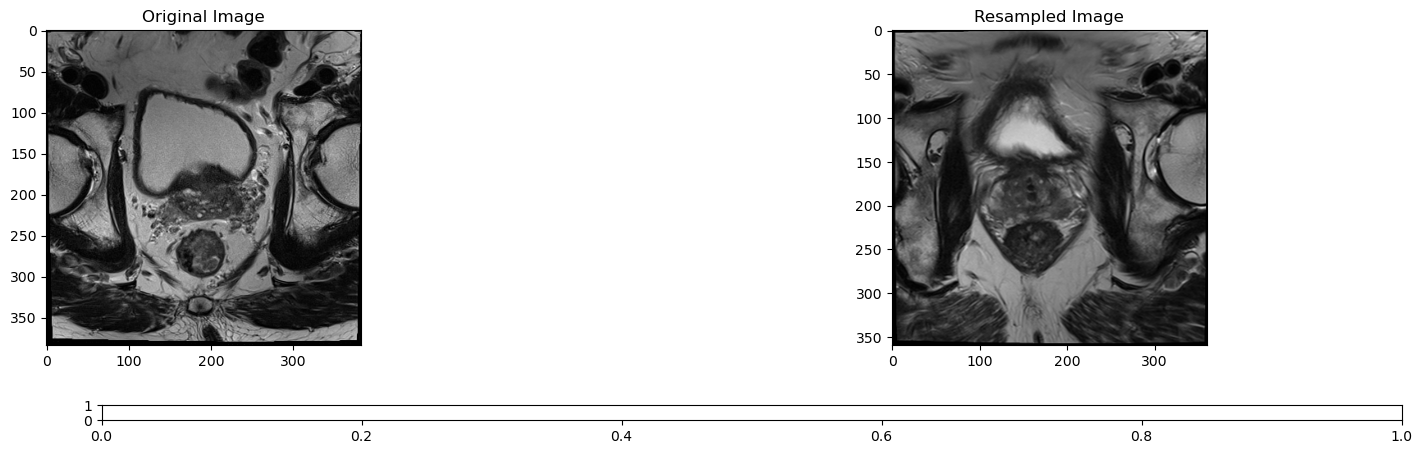

In [148]:
file_path_raw = r"Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha"
file_path_resampled = r"Data\t2w_spacing_resampled\resampled0\10000_1000000_t2w_resampled.mha"
image_raw = sitk.ReadImage(file_path_raw)
image_resampled = sitk.ReadImage(file_path_resampled)
image_data_raw = sitk.GetArrayFromImage(image_raw)
image_data_resampled = sitk.GetArrayFromImage(image_resampled)

print(f"Image shape: {image_data_raw.shape}")
print(f"Resampled image shape: {image_data_resampled.shape}")
print(f"Original spacing: {image_raw.GetSpacing()}")
print(f"Resampled spacing: {image_resampled.GetSpacing()}")
print(f"Intensity range: [{image_data_raw.min()}, {image_data_raw.max()}]")
print(f"Resampled intensity range: [{image_data_resampled.min()}, {image_data_resampled.max()}]")



fig, ax = plt.subplots(1, 2, figsize=(20, 5))

plt.subplots_adjust(bottom=0.25)

axlayer = plt.axes([0.25, 0.1, 0.65, 0.03])

ax[0].imshow(image_data[16, :, :], cmap='gray')
ax[0].set_title("Original Image")

ax[1].imshow(image_data_resampled[16, :, :], cmap='gray')
ax[1].set_title("Resampled Image")

plt.show()


  patient_id                                           T2w_path
0      10000  Data\t2w_spacing_resampled\resampled0\10000_10...
1      10003  Data\t2w_spacing_resampled\resampled0\10003_10...
2      10006  Data\t2w_spacing_resampled\resampled0\10006_10...
3      10022  Data\t2w_spacing_resampled\resampled0\10022_10...
4      10023  Data\t2w_spacing_resampled\resampled0\10023_10...
                                     Nii_gz_path patient_id
0  Data\Guerbet23_resampled\10000_1000000.nii.gz      10000
1  Data\Guerbet23_resampled\10003_1000003.nii.gz      10003
2  Data\Guerbet23_resampled\10004_1000004.nii.gz      10004
3  Data\Guerbet23_resampled\10005_1000005.nii.gz      10005
4  Data\Guerbet23_resampled\10006_1000006.nii.gz      10006
                                 Nii_gz_path patient_id
0  Data\Human_resampled\10000_1000000.nii.gz      10000
1  Data\Human_resampled\10003_1000003.nii.gz      10003
2  Data\Human_resampled\10004_1000004.nii.gz      10004
3  Data\Human_resampled\10005_10

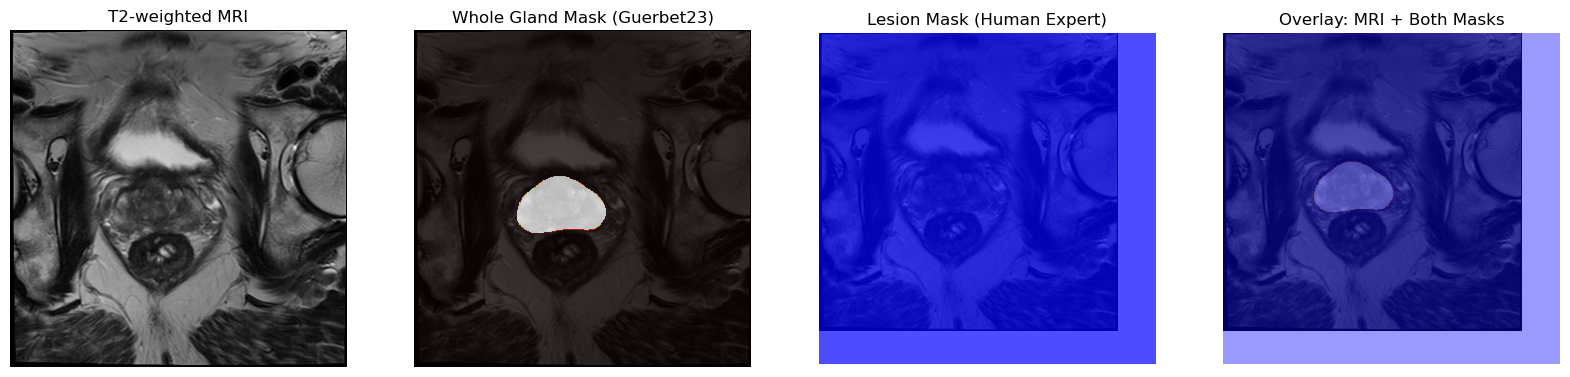

In [185]:

fileInfoT2w = '_t2w_resampled.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI_resampled, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_resampled_whole_gland_Guerbet23, combined_ids, fileInfo)
Human_nii_gz_paths = find_t2W_files(source_PI_CAI_resampled_Human, combined_ids, fileInfo)

t2w_patient_ids = [path.split('\\')[-1].split("_")[0] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
Human_nii_gz_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Human_nii_gz_paths]

t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Nii_gz_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
Human_df = pd.DataFrame({'Nii_gz_path': Human_nii_gz_paths, 'patient_id': Human_nii_gz_patient_ids})
print(t2w_df.head())
print(Guerbet23_df.head())
print(Human_df.head())
df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')

if not df_path_merged_Guerbet23.empty and not df_path_merged_Human.empty:
    patient_id = df_path_merged_Guerbet23.iloc[0]['patient_id'] 
    t2w_path = df_path_merged_Guerbet23.iloc[0]['T2w_path']
    guerbet23_mask_path = df_path_merged_Guerbet23.iloc[0]['Nii_gz_path']
    human_mask_path = df_path_merged_Human.iloc[0]['Nii_gz_path']

    t2w_image = load_nifti_image(t2w_path)
    guerbet23_mask = load_nifti_image(guerbet23_mask_path)
    human_mask = load_nifti_image(human_mask_path) 

    t2w_image = t2w_image / np.max(t2w_image)

    mid_slice = t2w_image.shape[0] // 2


    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(t2w_image[mid_slice], cmap='gray')
    ax[0].set_title("T2-weighted MRI")

    ax[1].imshow(t2w_image[mid_slice], cmap='gray')
    ax[1].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.7)
    ax[1].set_title("Whole Gland Mask (Guerbet23)")

    ax[2].imshow(t2w_image[mid_slice], cmap='gray')
    ax[2].imshow(human_mask[mid_slice], cmap='winter', alpha=0.7)
    ax[2].set_title("Lesion Mask (Human Expert)")

    ax[3].imshow(t2w_image[mid_slice], cmap='gray')
    ax[3].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
    ax[3].imshow(human_mask[mid_slice], cmap='winter', alpha=0.4)
    ax[3].set_title("Overlay: MRI + Both Masks")

    for a in ax:
        a.axis("off")

    plt.show()
else:
    print("Merged DataFrames are empty. Please check the input data.")

In [187]:
guerbet23_mask_img = sitk.ReadImage(guerbet23_mask_path)
human_mask_img = sitk.ReadImage(human_mask_path)
#print(f"Whole Gland Mask shape {guerbet23_mask_img.shape}")
#print(f"Lesion Mask shape {human_mask_img.shape}")
print(f"Image size: {image_raw.GetSize()}")
print(f"Resampled image size: {image_resampled.GetSize()}")
print(f"Whole Gland Mask size: {guerbet23_mask_img.GetSize()}")
print(f"Lesion Mask size: {human_mask_img.GetSize()}")
print(f"Image spacing: {human_mask_img.GetSpacing()}")

Image size: (640, 640, 31)
Resampled image size: (360, 360, 34)
Whole Gland Mask size: (360, 360, 34)
Lesion Mask size: (407, 400, 34)
Image spacing: (0.5, 0.5, 3.0)


In [5]:
extractor = featureextractor.RadiomicsFeatureExtractor()

# Print default settings
print("Default Settings:")
print(extractor.settings)

# Print enabled features by default
print("\nEnabled Features:")
print(extractor.enabledFeatures)

Default Settings:
{'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}

Enabled Features:
{'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
